# Tutorial and Sample Code for Balancing a Pole on a Cart

# Parts before developing the agent are from the the step by step tutorial from https://github.com/yue-zhongqi/cartpole_colab

# Executed on **Google Colab Linux Virtual Machine**.

# **Tested to execute on windows and mac jupyter notebook, but there were compatibility issues with quite a number of things(The issue on rendering of the environment and also mismatch of dimensions of tuple and arrays). Even when I debugged all the dimension issues, the learning is stuck at 0/300 for almost an hour, which indicates some form of problem since in Colab it takes ~1second for each episode. After some research, I excluded other possibilities and concluded that it may be due to some incompatibility issue.** 

# **Since the gym environment is designed to run on linux, it may not be executable under mac/windows jupyter notebook. Please upload to google colab to execute/use linux environment to execute.**


Done by Yang Yichen, Matriculation number U2121540A, Tutorial group A54




## Installing dependencies:

In [1]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym[classic_control]
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Importing dependencies and define helper functions

In [2]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

## Tutorial: Loading CartPole environment

In [3]:
env = gym.make("CartPole-v1")

We can check the action and observation space of this environment. Discrete(2) means that there are two valid discrete actions: 0 & 1.

In [4]:
print(env.action_space)

Discrete(2)


The observation space is given below. The first two arrays define the min and max values of the 4 observed values, corresponding to cart position, velocity and pole angle, angular velocity.

In [5]:
print(env.observation_space)

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


We call each round of the pole-balancing game an "episode". At the start of each episode, make sure the environment is reset, which chooses a random initial state, e.g., pole slightly tilted to the right. This initialization can be achieved by the code below, which returns the observation of the initial state.

In [6]:
observation = env.reset()
print("Initial observations:", observation)

Initial observations: [ 0.03242755 -0.02902926 -0.02734198  0.03120555]


For the CartPole environment, there are two possible actions: 0 for pushing to the left and 1 for pushing to the right. For example, we can push the cart to the left using code below, which returns the new observation, the current reward, an indicator of whether the game ends, and some additional information (not used in this project). For CartPole, the game ends when the pole is significantly tilted or you manage to balance the pole for 500 steps. You get exactly 1 reward for each step before the game ends (i.e., max cumulative reward is 500).

In [7]:
observation, reward, done, info = env.step(0)
print("New observations after choosing action 0:", observation)
print("Reward for this step:", reward)
print("Is this round done?", done)

New observations after choosing action 0: [ 0.03184696 -0.22374865 -0.02671787  0.31513795]
Reward for this step: 1.0
Is this round done? False


Now we can play a full round of the game using a naive strategy (always choosing action 0), and show the cumulative reward in the round. Note that reward returned by env.step(*) corresponds to the reward for current step. So we have to accumulate the reward for each step. Clearly, the naive strategy performs poorly by surviving only a dozen of steps.

In [8]:
observation = env.reset()
cumulative_reward = 0
done = False
while not done:
    observation, reward, done, info = env.step(0)
    cumulative_reward += reward
print("Cumulative reward for this round:", cumulative_reward)
env.close()

Cumulative reward for this round: 10.0


## Task 1: Development of an RL agent

After attempting to use a traditional DQN agent, I realised it is not performing very well both in the score and the memory, the capacity of the collab memory supports up to 300 episodes of training before the RAM of collab virtual machine runs out, by then the score will be around 200, which I think is a poor performance considering it trained for an hour and used 10+GB.

Hence I turned to use the evolution strategy to develop the agent. This algorithm performs better under limited memory conditions such as in collab. This algorithm toggles the weights of the neural network directly, in hope to maximise the outcome, unlike the traditional RL algorithms that tries random actions in the action space to maximise the outcome.

Refering to the ES model developed by Adriel-M, at (https://gist.github.com/Adriel-M/88c17591a2a468cb61ceac7bf15a6cf2), I learnt the basic idea of randomly generating weights and evaluating their performance. However in the model by Adriel-M, the rewards are calculated simply by multiplying the weight with their respective rewards, which is not very efficient considering there may be a few 'lucky' episodes that performed extremely well, which brings heavy attention to the episode, causing unstable updates that may bring the agent to evolve in a wrong direction.

Hence, I am adding the additional lines to normalize the reward, making the reward to distribute normally around 0. This will help to reduce the effect of outliers in the learning process, increasing the stability and hence the efficiency of the model. Theoretically the standard deviation of the weight should also be recorded and updated in each cycle, but for simplicity sake, I am fixing the standard deviation at 1, in this cas it is still efficient enough to produce good result.

In [9]:
env = gym.make('CartPole-v1')
#Initial parameters, final values are determined by trial and error.
population_size = 50
sigma = 0.1
learning_rate = 0.01
num_iterations = 300

#defining the initial guess weight to be 0, which is the mean of standard normal distribution
#Since there are 4 variables in the observational space, and 2 variables in the action space, the Numpy array is defined with size of 4x2.
guess = np.zeros((4, 2))

#function to simulate Gaussian distrubution required for ES. Returns set of weights 
def get_weights():
    weights = np.zeros((4, 2))
    #initialise the Numpy 4x2 array by filling it with 0.
    for i in range(4):
        weights[i] = np.random.normal(guess[i], 1)# for each guess, the standard deviation is fixed at 1 for simplicity. 
        #get random weight by choosing a point from the previously defined normal distribution function.
    return weights

#function for the agent to play an episode using the set of generated weights and returns the result
def get_reward(weights):
    cumulative_reward = 0
    done = False
    observation= env.reset()
    #making the empty tuple behind the observations to disappear
    while not done:
        action = np.argmax(np.dot(observation, weights))
        #The dot product of observation and weights gives the set of Q-values for the state-action sets for each observation and weight.
        #The argmax function finds the maximum Q-value's corresponding index, and put that into the action. Hence the action chosen in this step is the action that is expected to give the highest reward.
        observation, reward, done, _ = env.step(action)[:4]
        cumulative_reward += reward
    return cumulative_reward

# Initialise the population using previously defined function.
population = [get_weights() for _ in range(population_size)]
# The population is obtained randomly from normal distribution

for i in range(num_iterations):
    #define an Numpy array to store the reward obtained by each set of weights
    print(i ,"/" , num_iterations)
    rewards = np.zeros(population_size)
    for j in range(population_size):
        rewards[j] = get_reward(population[j])
        #store the reward values for each set of randomly generated weights, to be processed later.
    if(rewards[0] == 500 and np.std(rewards) == 0): 
      break
      #Make the RL agent to stop if the agent is already well trained and not learning anything new, e.g. all rewards are max score.
      #Also to avoid division by zero if np.std(rewards) == 0, in the next step, which will return a set of NaN values for best weights and cause the agent to fail.
    rewards_normalized = (rewards - np.mean(rewards)) / np.std(rewards)
    #normalize the set of reward values, to make the distribution of rewards to have mean of 0 and standard deviation of 1
    #This step helps to increase the efficiency of the algorithm, by making the update process more stable.
    weighted_population = np.array([p * r for p, r in zip(population, rewards_normalized)])
    #The weighted population array contains the product of the set of weight in population, and their corresponding normalized reward value.
    guess += learning_rate * np.sum(weighted_population, axis=0)/ (population_size * sigma)
    #Make a new guess by the weight updating formula for the ES algorithm(from Adriel-M).
    population = [get_weights() for _ in range(population_size)]
    # Generate new population for another round of iteraton.

#Weights that performed best from the rounds of iterations
best_weights = population[np.argmax([get_reward(weights) for weights in population])]
print('Best weights:', best_weights)
#Show the values of set of best weights.
env.close()
#save the set of best weights for use in later evalutions and tasks.
np.save("cartpole-es.npy", best_weights)


0 / 300
1 / 300
2 / 300
3 / 300
4 / 300
5 / 300
6 / 300
7 / 300
8 / 300
9 / 300
10 / 300
11 / 300
12 / 300
13 / 300
14 / 300
15 / 300
16 / 300
17 / 300
18 / 300
19 / 300
20 / 300
21 / 300
22 / 300
23 / 300
24 / 300
25 / 300
26 / 300
27 / 300
28 / 300
29 / 300
30 / 300
31 / 300
32 / 300
33 / 300
34 / 300
35 / 300
36 / 300
37 / 300
38 / 300
39 / 300
40 / 300
41 / 300
42 / 300
43 / 300
44 / 300
45 / 300
46 / 300
47 / 300
48 / 300
49 / 300
50 / 300
51 / 300
52 / 300
53 / 300
54 / 300
55 / 300
56 / 300
57 / 300
58 / 300
59 / 300
60 / 300
61 / 300
62 / 300
63 / 300
64 / 300
65 / 300
66 / 300
67 / 300
68 / 300
69 / 300
70 / 300
71 / 300
72 / 300
73 / 300
74 / 300
75 / 300
76 / 300
77 / 300
78 / 300
79 / 300
80 / 300
81 / 300
82 / 300
83 / 300
84 / 300
85 / 300
86 / 300
87 / 300
88 / 300
89 / 300
90 / 300
91 / 300
92 / 300
93 / 300
94 / 300
95 / 300
96 / 300
97 / 300
98 / 300
99 / 300
100 / 300
101 / 300
102 / 300
103 / 300
104 / 300
105 / 300
106 / 300
107 / 300
108 / 300
109 / 300
110 / 300


For Task 1, we can show the observation and chosen action below:

In [10]:
env = gym.make('CartPole-v1')
best_weights = np.load('cartpole-es.npy') 
# Reset the environment and get the initial state
observation = env.reset()
action = np.argmax(np.dot(observation, best_weights))
 #The Q values are determined from the dot product of state-action set (observation and best_weights), and the best value is chosen using agrmax()
observation, reward, done, info = env.step(action)
 #Take the action determined by the previous step
print("Observation:", observation)
print("Chosen action:", action)
env.close()

Observation: [ 0.02681473  0.21701775 -0.00862477 -0.26352543]
Chosen action: 1


## Task 2: Demonstrate the effectiveness of the RL agent

For this task, use the agent developed in Task 1 to play the game for 100 episodes (refer to tutorial for how to play a round), record the cumulative reward for each round, and plot the reward for each round. A sample plotting code is given below. Note that you must include code to play for 100 episodes and use the code to obtain round_results for plotting. DO NOT record the round results in advance and paste the results to the notebook.

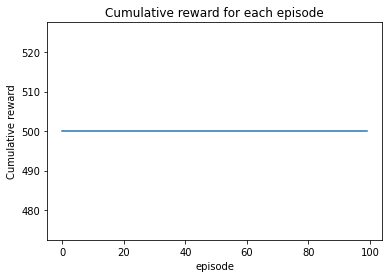

In [11]:
num_episodes = 100
episode_results = []
#load the best weights and use it to make decisions
best_weights = np.load('cartpole-es.npy') 
env = gym.make('CartPole-v1')
for episode in range(100):
    observation = env.reset()
    score = 0
    done = False
    while not done:
        action = np.argmax(np.dot(observation, best_weights))
        #The Q values are determined from the dot product of state-action set (observation and best_weights), and the best value is chosen using agrmax()
        observation, reward, done, info = env.step(action)
        #Take the action determined by the previous step
        score += reward
        #add the reward to the score for this round
    episode_results.append(score)
    #append the final score for each round

env.close()
plt.plot(episode_results)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

Print the average reward over the 100 episodes.

In [12]:
print("Average cumulative reward:", sum(episode_results)/len(episode_results))
print("Is my agent good enough?", sum(episode_results)/len(episode_results) > 195)

Average cumulative reward: 500.0
Is my agent good enough? True


## Task 3: Render one episode played by the agent

Plug your agent to the code below to obtain rendered result.

In [13]:
env = RecordVideo(gym.make("CartPole-v1"), "./video")
observation = env.reset()
best_weights = np.load('cartpole-es.npy') 
while True:
    env.render()
    #your agent goes here
    action = np.argmax(np.dot(observation, best_weights))
    observation, reward, done, info = env.step(action)
    if done: 
      break;    
env.close()
show_video()